In [ ]:
from transformers import pipeline, AutoTokenizer, GPT2LMHeadModel
import torch
import torch.nn as nn
import math
from torch.utils.data import DataLoader, Dataset
from dataclasses import dataclass
import inspect
import os
import numpy as np
import torch.nn.functional as F
import time

# Model Defining

In [ ]:
class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        # flash attention make GPU go brrrrr but support is only in PyTorch >= 2.0
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            # causal mask to ensure that attention is only applied to the left in the input sequence
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                        .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        if self.flash:
            # efficient attention using Flash Attention CUDA kernels
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        else:
            # manual implementation of attention
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        # with weight tying when using torch.compile() some warnings get generated:
        # "UserWarning: functional_call was passed multiple values for tied weights.
        # This behavior is deprecated and will be an error in future versions"
        # not 100% sure what this is, so far seems to be harmless. TODO investigate
        self.transformer.wte.weight = self.lm_head.weight # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss


    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
        # start with all of the candidate parameters
        param_dict = {pn: p for pn, p in self.named_parameters()}
        # filter out those that do not require grad
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        extra_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
        print(f"using fused AdamW: {use_fused}")

        return optimizer

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

# Dataset Loader

## New loader

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bolbolzaban/gpt2-persian')
# tokenizer = AutoTokenizer.from_pretrained("gpt2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# download data set
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

# Define Kaggle dataset details
dataset = 'aminghd/large-corpus-of-farsi-poems'

file_names = ['parvin_norm.txt','gilani_norm.txt','shahriar_norm.txt','khosro_norm.txt']



# Initialize variables to store the word count, max line length, and number of lines
total_words = 0
max_line_length = 0
num_lines = 0

for file_name in file_names:
    # Download the specific file from the Kaggle dataset
    api.dataset_download_file(dataset, file_name)

    # Check if the file is downloaded and unzipped correctly
    if not os.path.exists(file_name):
        os.system(f'unzip {file_name}.zip')

Dataset URL: https://www.kaggle.com/datasets/aminghd/large-corpus-of-farsi-poems
Dataset URL: https://www.kaggle.com/datasets/aminghd/large-corpus-of-farsi-poems
Dataset URL: https://www.kaggle.com/datasets/aminghd/large-corpus-of-farsi-poems
Dataset URL: https://www.kaggle.com/datasets/aminghd/large-corpus-of-farsi-poems


In [ ]:
formatted_lines = []
poets = ['پروین', 'گیلانی', 'شهریار', 'خسرو']
for idx, file_name in enumerate(file_names):
    with open(file_name, 'r', encoding='utf-8') as file:
        lines = [line.strip() for line in file.readlines() if line.strip()]

    # Iterate over the lines in pairs and format them with special tokens
    for i in range(0, len(lines)):
        last_step = i+1 == len(lines)
        if last_step:
            break
        else:
            formatted_line = f"[CLS]{poets[idx]}[CLS] [BOM] {lines[i]} [BOM] {lines[i+1]} [EOS]"
            formatted_lines.append(formatted_line)

couplet = formatted_lines.copy()

In [ ]:
formatted_lines[-10:]

['[CLS]خسرو[CLS] [BOM] اگر چه بسی دردها هست  لیکن [BOM] جداگانه دردی است درد جدایی [EOS]',
 '[CLS]خسرو[CLS] [BOM] جداگانه دردی است درد جدایی [BOM] چو دیدی که هستی بقایی ندارد [EOS]',
 '[CLS]خسرو[CLS] [BOM] چو دیدی که هستی بقایی ندارد [BOM] ز هستی چه لافی درین لابقایی [EOS]',
 '[CLS]خسرو[CLS] [BOM] ز هستی چه لافی درین لابقایی [BOM] مرو بهر مشتی درم نزد هر خس [EOS]',
 '[CLS]خسرو[CLS] [BOM] مرو بهر مشتی درم نزد هر خس [BOM] مکن خدمت گاو چون روستایی [EOS]',
 '[CLS]خسرو[CLS] [BOM] مکن خدمت گاو چون روستایی [BOM] به جیب فلک خسروا دست در کن [EOS]',
 '[CLS]خسرو[CLS] [BOM] به جیب فلک خسروا دست در کن [BOM] بهر جا چو دو نان چه دامن گشایی [EOS]',
 '[CLS]خسرو[CLS] [BOM] بهر جا چو دو نان چه دامن گشایی [BOM] هر جا که لعلش در خنده آید [EOS]',
 '[CLS]خسرو[CLS] [BOM] هر جا که لعلش در خنده آید [BOM] شکر ندارد آنجا بهاییی [EOS]',
 '[CLS]خسرو[CLS] [BOM] شکر ندارد آنجا بهاییی [BOM] هر لحظه دارد دل با خیالش [EOS]']

In [ ]:
# Check the number of sentences
num_couplet = len(couplet)
print(f"Number of couplet: {num_couplet}")

# Ensure there are enough sentences to split
if num_couplet > 1:
    # Calculate the split index
    split_index = int(num_couplet * 0.95)

    # Split data into training and validation sets (90% training, 10% validation)
    train_couplet = couplet[:split_index]
    val_couplet = couplet[split_index:]

    # Concatenate all training and validation sentences into single texts
    train_text = ''.join(train_couplet)
    val_text = ''.join(val_couplet)

    print(f"Number of training couplet: {len(train_couplet)}")
    print(f"Number of validation couplet: {len(val_couplet)}")
else:
    print("Not enough couplet to split. Please provide more data.")

Number of couplet: 62793
Number of training couplet: 59653
Number of validation couplet: 3140


In [ ]:
train_data = tokenizer.encode(train_text, add_special_tokens=False)
val_data = tokenizer.encode(val_text, add_special_tokens=False)

In [ ]:
tokenizer.decode(train_data[150:250])

'شمار جدی و عقرب و جوزا را[EOS][CLS] پروین[CLS][BOM] مشمار جدی و عقرب و جوزا را[BOM] دور است کاروان سحر زینجا[EOS][CLS] پروین[CLS][BOM] دور است کاروان سحر زینجا[BOM] شمعی بباید این شب یلدا را[EOS][CLS] پروین[CLS][BOM] شمعی بباید این شب یلدا را[BOM] در پرده صد هزار سیه کاریست[EOS][CLS] پروین[CLS][BOM] در پرده صد هزار سیه کاریست[BOM] این تند سیر گنبد خضرا را[EOS][CLS] پروین[CLS][BOM] این تند سیر گنبد خضرا را[BOM] پیوند او'

## NeXT Loader

In [ ]:
def load_tokens(list_token):
    ptt = torch.tensor(list_token, dtype=torch.long)
    return ptt

class DataLoaderLite:
    def __init__(self, B, T, tokens_tensor):
        self.B = B
        self.T = T
        self.current_position = 0
        self.reset(tokens_tensor)

    def reset(self, tokens_tensor):
        self.tokens = load_tokens(tokens_tensor)
        self.current_position = 0  # Reset position whenever tokens are reset

    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position : self.current_position+B*T+1]
        x = (buf[:-1]).view(B, T) # inputs
        y = (buf[1:]).view(B, T) # targets
        # advance the position in the tensor
        self.current_position += B * T
        # if loading the next batch would be out of bounds, advance to next shard
        if self.current_position + (B * T + 1) > len(self.tokens):
            self.current_position = 0
        return x, y



**Testing** dataloader

In [ ]:
# batch_size = 256
# block_size = 64
B = 86 # micro batch size
T = 256 # sequence length

train_loader = DataLoaderLite(B=B, T=T, tokens_tensor=train_data)
val_loader = DataLoaderLite(B=B, T=T, tokens_tensor=val_data)

In [ ]:
train_data_tokens = len(train_data)
val_data_tokens = len(val_data)

In [ ]:
print(f"Numbers of training tokens: {train_data_tokens}")
print(f"Numbers of validation tokens: {val_data_tokens}")

Numbers of training tokens: 1285383
Numbers of validation tokens: 69301


# PreTraining Step

In [ ]:
@dataclass
class GPTConfig:
    block_size: int = 256
    vocab_size: int = 25000
    n_layer: int = 11
    n_head: int = 8
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = False

In [ ]:
master_process = True
# attempt to autodetect device
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"using device: {device}")

# added after video, pytorch can be serious about it's device vs. device_type distinction
device_type = "cuda" if device.startswith("cuda") else "cpu"

torch.manual_seed(1337)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)

# enc = tokenizer.encoder

total_batch_size = train_data_tokens // 10 # in number of tokens in total batch
B = 86 # micro batch size
T = 256 # sequence length

grad_accum_steps = total_batch_size // (B * T)
if master_process:
    print(f"total desired batch size: {total_batch_size}")
    print(f"=> calculated gradient accumulation steps: {grad_accum_steps}")

train_loader = DataLoaderLite(B=B, T=T, tokens_tensor=train_data)
val_loader = DataLoaderLite(B=B, T=T, tokens_tensor=val_data)

torch.set_float32_matmul_precision('high')

# create model
model = GPT(GPTConfig) # we set vocab_size to a nice number after unique_tokens we use 11648
# model = GPT.from_pretrained("bolbolzaban/gpt2-persian") # or init from OpenAI GPT-2
# model = GPT.from_pretrained("gpt2") # or init from OpenAI GPT-2
model.to(device)
# use_compile = False # torch.compile interferes increase speed
# if use_compile:
#     model = torch.compile(model)

raw_model = model


# # cosine learning decay
# max_lr = 6e-4
# min_lr = max_lr * 0.1
# warmup_steps = 715
max_steps = 10  # 10 steps is ~1 epoch, if data is train_data_tokens tokens and batch size train_data_tokens/10 tokens
# def get_lr(it):
#     # 1) linear warmup for warmup_iters steps
#     if it < warmup_steps:
#         return max_lr * (it+1) / warmup_steps
#     # 2) if it > lr_decay_iters, return min learning rate
#     if it > max_steps:
#         return min_lr
#     # 3) in between, use cosine decay down to min learning rate
#     decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
#     assert 0 <= decay_ratio <= 1
#     coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff starts at 1 and goes to 0
#     return min_lr + coeff * (max_lr - min_lr)

# optimize!
optimizer = model.configure_optimizers(weight_decay=0.1, learning_rate=3e-4, betas=(0.9, 0.95), device_type=device)

# create the log directory we will write checkpoints to and log to
log_dir = "log"
os.makedirs(log_dir, exist_ok=True)
log_file = os.path.join(log_dir, f"log.txt")
with open(log_file, "w") as f: # open for writing to clear the file
    pass

using device: cuda
total desired batch size: 128538
=> calculated gradient accumulation steps: 5
number of parameters: 97.07M
num decayed parameter tensors: 46, with 97,253,376 parameters
num non-decayed parameter tensors: 23, with 17,664 parameters
using fused AdamW: True


# Training Loop

In [ ]:
epoch = 200

In [ ]:
for e in range(epoch):
    print(f"EPOCH {e+1}:")
    for step in range(max_steps):
        t0 = time.time()
        last_step = (step == (max_steps - 1))
        # once in a while evaluate our validation loss
        if (e+1) % 4 == 0 and last_step:
            model.eval()
            val_loader.reset(val_data)
            with torch.no_grad():
                val_loss_accum = 0.0
                val_loss_steps = val_data_tokens // (B*T)
                for _ in range(val_loss_steps):
                    x, y = val_loader.next_batch()
                    x, y = x.to(device), y.to(device)
                    with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
                        logits, loss = model(x, y)
                    loss = loss / val_loss_steps
                    val_loss_accum += loss.detach()
            if master_process:
                print(f"validation loss: {val_loss_accum.item():.4f}")
                with open(log_file, "a") as f:
                    f.write(f"{step} val {val_loss_accum.item():.4f}\n")

        # do one step of the optimization
        model.train()
        optimizer.zero_grad()
        loss_accum = 0.0
        for micro_step in range(grad_accum_steps):
            x, y = train_loader.next_batch()
            x, y = x.to(device), y.to(device)
            with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
                logits, loss = model(x, y)
            # we have to scale the loss to account for gradient accumulation,
            # because the gradients just add on each successive backward().
            # addition of gradients corresponds to a SUM in the objective, but
            # instead of a SUM we want MEAN. Scale the loss here so it comes out right
            loss = loss / grad_accum_steps
            loss_accum += loss.detach()
            loss.backward()
        # get norm of params to see how they fluctuating while training and updating
        norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # determine and set the learning rate for this iteration
        # lr = get_lr(step) # remove learning rate decay to converge faster
        # for param_group in optimizer.param_groups:
        #     param_group['lr'] = lr
        optimizer.step()
        if device_type == "cuda":
            torch.cuda.synchronize() # wait for the GPU to finish work
        t1 = time.time()
        dt = t1 - t0 # time difference in seconds
        tokens_processed = train_loader.B * train_loader.T * grad_accum_steps
        tokens_per_sec = tokens_processed / dt
        if master_process:
            # print(f"step {step:5d} | loss: {loss_accum.item():.6f} | lr {lr:.4e} | norm: {norm:.4f} | dt: {dt*1000:.2f}ms | tok/sec: {tokens_per_sec:.2f}")
            print(f"step {step:5d} | loss: {loss_accum.item():.6f} | norm: {norm:.4f} | dt: {dt*1000:.2f}ms | tok/sec: {tokens_per_sec:.2f}")
            with open(log_file, "a") as f:
                f.write(f"{step} train {loss_accum.item():.6f}\n")

Truncate Results

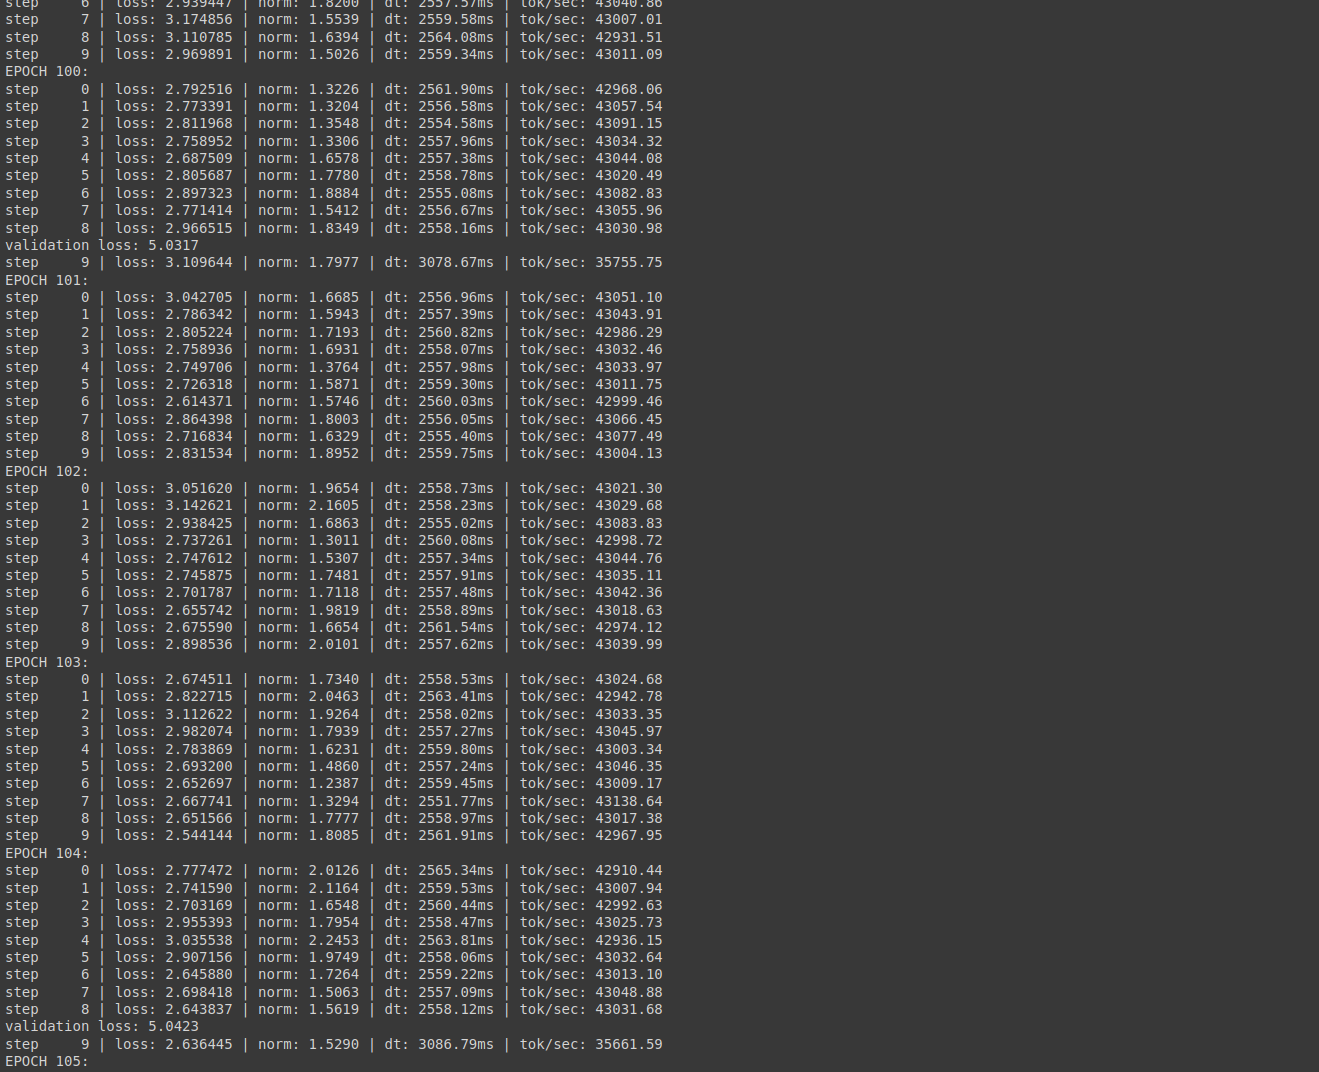

In [ ]:
max_new_tokens = 65 # number of tokens generated in each sample
temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 200 # retain only the top_k most likely tokens, clamp others to have 0 probability
start = "[CLS]خسرو[CLS]"
start_ids = tokenizer.encode(start, add_special_tokens=False)
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

# run generation
num_samples = 4
with torch.no_grad():
    with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
        for k in range(num_samples):
            y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
            print(tokenizer.decode(y[0].tolist()))
            print('---------------')

[CLS] خسرو[CLS][BOM] از هر شب که از باد دو اهل وفا آگه می کنی[BOM] به روز اهل حسن عشق که از سر پر می کنی[BOM] به سر سر ستم ره عشق که از سر نیاید[EOS][CLS] خسرو[CLS][BOM] به سر درون ره سرکش سر بشکن[BOM] فتنه سر دیگر ز سر نمی شود ز غم[EOS][CLS] خسرو[CLS][BOM] دلت
---------------
[CLS] خسرو[CLS][BOM] که رخت غم زلف من تو بر مهست او[BOM] شرح غنچه و در خواب شیرین مه و پری بالشش[EOS][CLS] خسرو[CLS][BOM] این هزار دیده ام نقش او و ابروی و ستاب[EOS][CLS] خسرو[CLS][BOM] این قصه سپردن بر سر لشکر فگن[BOM] گر به بر سر ره کوی او کشید در دماغ[EOS][CLS]
---------------
[CLS] خسرو[CLS][BOM] در جمال تو به پیش تو یک سو دو سال[BOM] هر قدم هر دو تن من بهم گداز جان خواهم که دوش خواهمش ازین سر آید از سر راه تو دری زیر زمین[EOS][CLS] خسرو[CLS][BOM] هر سر هر نظر هر شب[BOM] خواهم بوسم و نآید پای[EOS][CLS] خسرو[CLS][BOM] نو 
---------------
[CLS] خسرو[CLS][BOM] وی عشق در جهان تو می گذرد[BOM] می گذرد شب که ز کویش روشنم[EOS][CLS] خسرو[CLS][BOM] می گذرد که می گذرد[BOM] چون منش در گل می گذرد استخوانت[EOS][CLS] خسرو[C

# Save State

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
checkpoint_path = os.path.join(log_dir, f"model_LARGE_V2.pth")
checkpoint = {
'model': model.state_dict(),
'optimizer': optimizer.state_dict(),
'config': model.config,
'val_loss': val_loss_accum.item()
}

torch.save(checkpoint, checkpoint_path)

In [ ]:
checkpoint_path

'log/model_LARGE_V2.pth'

In [ ]:
!cp log/model_LARGE_V2.pth /content/drive/MyDrive/Weghts